# Evaluating Machine Learning for Medical Diagnosis of Chronic Kidney Disease (CKD)

This notebook covers:
1. Impactful EDA
2. Null handling & preprocessing
3. Standardization
4. Model training & evaluation (LogReg, DT, RF, SVM, KNN, GB, XGBoost*)
5. ANN and DNN (MLPClassifier)
6. Performance comparison table


## 0. Setup


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# If running in Colab, you can uncomment the next line to ensure xgboost is installed
!pip -q install xgboost


## 1. Imports

In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix, RocCurveDisplay)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# Optional: XGBoost
try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except Exception as e:
    HAS_XGB = False
    print("XGBoost not available; will skip.")

sns.set(context="notebook", style="whitegrid")
pd.set_option("display.max_columns", 200)

## 2. Load Data


In [ ]:
#@title Load the dataset from Google Drive
CSV_PATH = '/content/drive/MyDrive/DataSets/kidney_disease.csv'

df = pd.read_csv(CSV_PATH)
print(df.shape)
df.head()

(400, 26)


,id,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,bu,sc,sod,pot,hemo,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,36.0,1.2,NaN,NaN,15.4,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,18.0,0.8,NaN,NaN,11.3,38,6000,NaN,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,53.0,1.8,NaN,NaN,9.6,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,56.0,3.8,111.0,2.5,11.2,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,26.0,1.4,NaN,NaN,11.6,35,7300,4.6,no,no,no,good,no,no,ckd


In [ ]:
col={'age': 'age',
     'bp': 'blood_pressure',
     'sg': 'specific_gravity',
     'al': 'albumin',
     'su': 'sugar',
     'rbc': 'red_blood_cells',
     'pc': 'pus_cell',
     'pcc': 'pus_cell_clumps',
     'ba': 'bacteria',
     'bgr': 'blood_glucose_random',
     'bu': 'blood_urea',
     'sc': 'serum_creatinine',
     'sod': 'sodium',
     'pot': 'potassium',
     'hemo': 'hemoglobin',
     'pcv': 'packed_cell_volume',
     'wc': 'white_blood_cell_count',
     'rc': 'red_blood_cell_count',
     'htn': 'hypertension',
     'dm': 'diabetes_mellitus',
     'cad': 'coronary_artery_disease',
     'appet': 'appetite',
     'pe': 'pedal_edema',
     'ane': 'anemia',
     'classification': 'class'}
df.rename(columns=col, inplace=True)
df


,id,age,blood_pressure,specific_gravity,albumin,sugar,red_blood_cells,pus_cell,pus_cell_clumps,bacteria,blood_glucose_random,blood_urea,serum_creatinine,sodium,potassium,hemoglobin,packed_cell_volume,white_blood_cell_count,red_blood_cell_count,hypertension,diabetes_mellitus,coronary_artery_disease,appetite,pedal_edema,anemia,class
0,0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,36.0,1.2,NaN,NaN,15.4,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,18.0,0.8,NaN,NaN,11.3,38,6000,NaN,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,53.0,1.8,NaN,NaN,9.6,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,56.0,3.8,111.0,2.5,11.2,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,26.0,1.4,NaN,NaN,11.6,35,7300,4.6,no,no,no,good,no,no,ckd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,395,55.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,140.0,49.0,0.5,150.0,4.9,15.7,47,6700,4.9,no,no,no,good,no,no,notckd
396,396,42.0,70.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,75.0,31.0,1.2,141.0,3.5,16.5,54,7800,6.2,no,no,no,good,no,no,notckd
397,397,12.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,100.0,26.0,0.6,137.0,4.4,15.8,49,6600,5.4,no,no,no,good,no,no,notckd
398,398,17.0,60.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,114.0,50.0,1.0,135.0,4.9,14.2,51,7200,5.9,no,no,no,good,no,no,notckd


## 3. Quick Data Overview

In [ ]:
print("Shape:", df.shape)
print("\nColumns:", list(df.columns))
print("\nDtypes:\n", df.dtypes)
print("\nMissing values (count):\n", df.isna().sum())
print("\nTarget preview (unique values):", df.iloc[:, -1].unique()[:10])  # last col often target in CKD dataset


Shape: (400, 26)

Columns: ['id', 'age', 'blood_pressure', 'specific_gravity', 'albumin', 'sugar', 'red_blood_cells', 'pus_cell', 'pus_cell_clumps', 'bacteria', 'blood_glucose_random', 'blood_urea', 'serum_creatinine', 'sodium', 'potassium', 'hemoglobin', 'packed_cell_volume', 'white_blood_cell_count', 'red_blood_cell_count', 'hypertension', 'diabetes_mellitus', 'coronary_artery_disease', 'appetite', 'pedal_edema', 'anemia', 'class']

Dtypes:
 id                           int64
age                        float64
blood_pressure             float64
specific_gravity           float64
albumin                    float64
sugar                      float64
red_blood_cells             object
pus_cell                    object
pus_cell_clumps             object
bacteria                    object
blood_glucose_random       float64
blood_urea                 float64
serum_creatinine           float64
sodium                     float64
potassium                  float64
hemoglobin                 

## 4. Target Identification & Cleaning Helpers


In [ ]:
TARGET_COL = 'class'

assert TARGET_COL in df.columns, f"'{TARGET_COL}' not found. Available: {df.columns.tolist()}"

# Clean strings: strip spaces, lower, normalize common binary labels
def clean_str(s):
    if pd.isna(s):
        return np.nan
    s = str(s).strip().lower()
    s = s.replace('\t', '').replace('?', '')
    return s

# Apply cleaning to object columns
for c in df.columns:
    if df[c].dtype == 'object':
        df[c] = df[c].apply(clean_str)

# Try to coerce numerics where possible
def coerce_numeric(col):
    return pd.to_numeric(col, errors='ignore')

df = df.apply(coerce_numeric)

# Common binary mappings for CKD dataset
binary_maps = {
    # yes/no style
    'yes_no': {'yes': 1, 'no': 0, 'y': 1, 'n': 0},
    # normal/abnormal
    'norm_ab': {'normal': 0, 'abnormal': 1},
    # present/absent
    'pres_abs': {'present': 1, 'absent': 0},
    # good/poor appetite
    'good_poor': {'good': 1, 'poor': 0}
}

for col in df.columns:
    if df[col].dtype == 'object':
        s = df[col]
        if set(s.dropna().unique()).issubset(set(binary_maps['yes_no'].keys())):
            df[col] = s.map(binary_maps['yes_no'])
        elif set(s.dropna().unique()).issubset(set(binary_maps['norm_ab'].keys())):
            df[col] = s.map(binary_maps['norm_ab'])
        elif set(s.dropna().unique()).issubset(set(binary_maps['pres_abs'].keys())):
            df[col] = s.map(binary_maps['pres_abs'])
        elif set(s.dropna().unique()).issubset(set(binary_maps['good_poor'].keys())):
            df[col] = s.map(binary_maps['good_poor'])

# Standardize target values to {0,1} if they look like 'ckd'/'notckd' or similar
if df[TARGET_COL].dtype == 'object':
    target_map = {'ckd': 1, 'notckd': 0, 'ckd\t': 1, 'ckd?': 1, 'not ckd': 0, 'no': 0, 'yes': 1}
    df[TARGET_COL] = df[TARGET_COL].map(lambda x: target_map.get(str(x).strip().lower(), x))

# If target is still object and not numeric 0/1, factorize
if not np.issubdtype(df[TARGET_COL].dtype, np.number):
    df[TARGET_COL], _ = pd.factorize(df[TARGET_COL])

# Ensure target is int
df[TARGET_COL] = df[TARGET_COL].astype(int)

print("Target value counts:")
print(df[TARGET_COL].value_counts())

Target value counts:
class
1    250
0    150
Name: count, dtype: int64


/tmp/ipython-input-3380391662.py:20: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  return pd.to_numeric(col, errors='ignore')


## 5. Impactful EDA

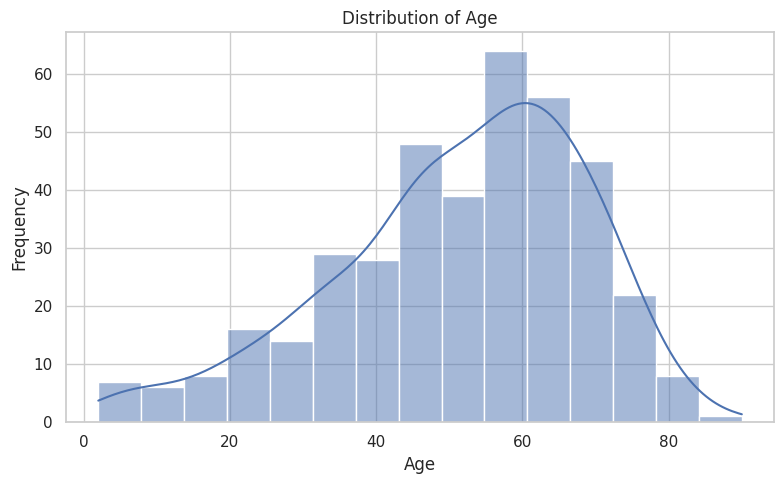


Available numeric columns:
['id', 'age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane']


In [ ]:
# Example: Distribution plot for 'age'
plt.figure(figsize=(8, 5))
sns.histplot(df['age'].dropna(), kde=True)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# You can change 'age' to any other numeric column from the list below:
print("\nAvailable numeric columns:")
print(num_cols)

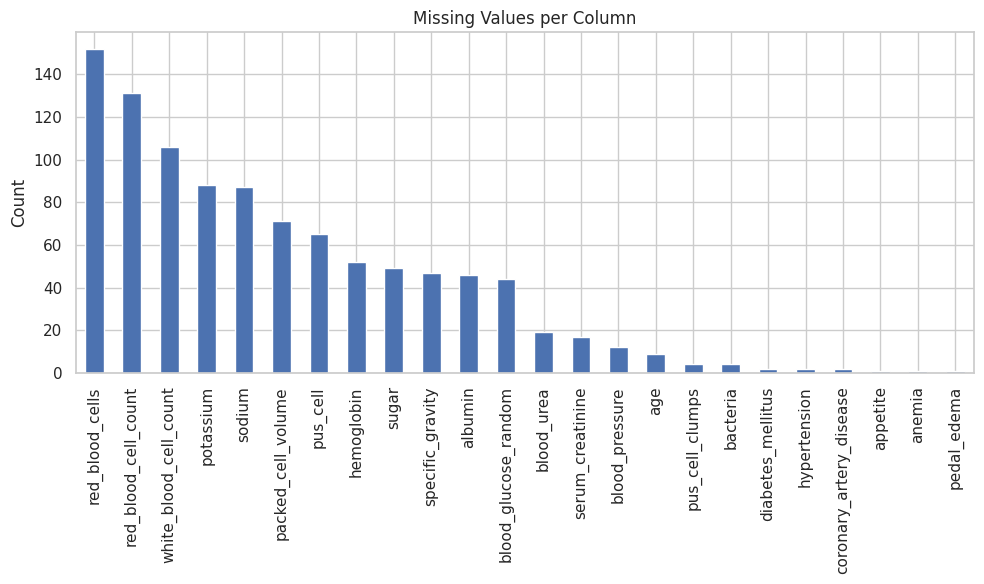

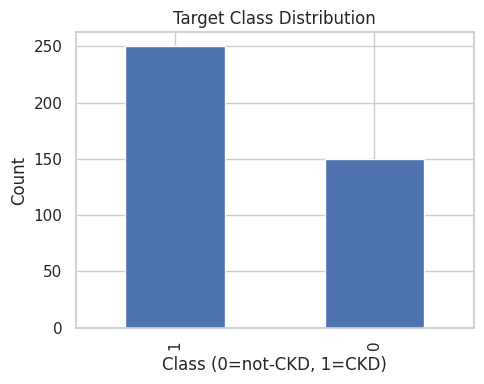

,count,mean,std,min,25%,50%,75%,max
id,400.0,199.500000,115.614301,0.000,99.75,199.50,299.25,399.000
age,391.0,51.483376,17.169714,2.000,42.00,55.00,64.50,90.000
blood_pressure,388.0,76.469072,13.683637,50.000,70.00,80.00,80.00,180.000
specific_gravity,353.0,1.017408,0.005717,1.005,1.01,1.02,1.02,1.025
albumin,354.0,1.016949,1.352679,0.000,0.00,0.00,2.00,5.000
sugar,351.0,0.450142,1.099191,0.000,0.00,0.00,0.00,5.000
red_blood_cells,248.0,0.189516,0.392711,0.000,0.00,0.00,0.00,1.000
pus_cell,335.0,0.226866,0.419431,0.000,0.00,0.00,0.00,1.000
blood_glucose_random,356.0,148.036517,79.281714,22.000,99.00,121.00,163.00,490.000
blood_urea,381.0,57.425722,50.503006,1.500,27.00,42.00,66.00,391.000


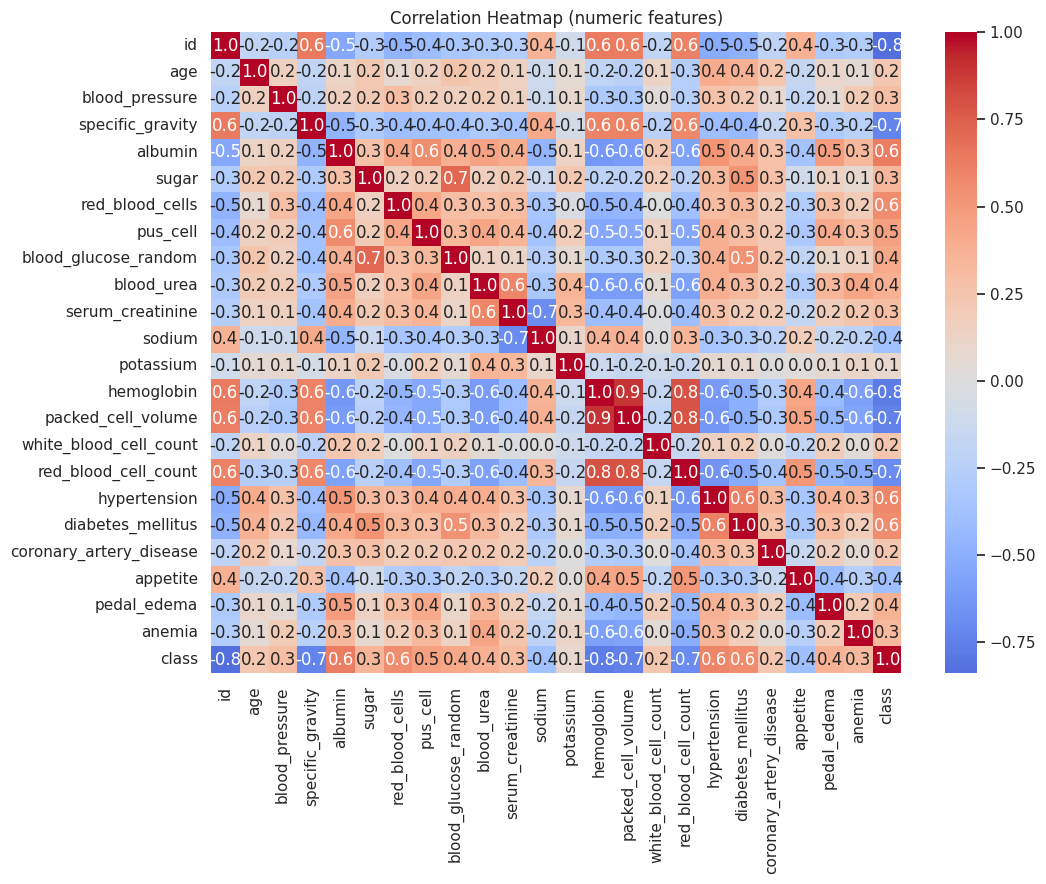

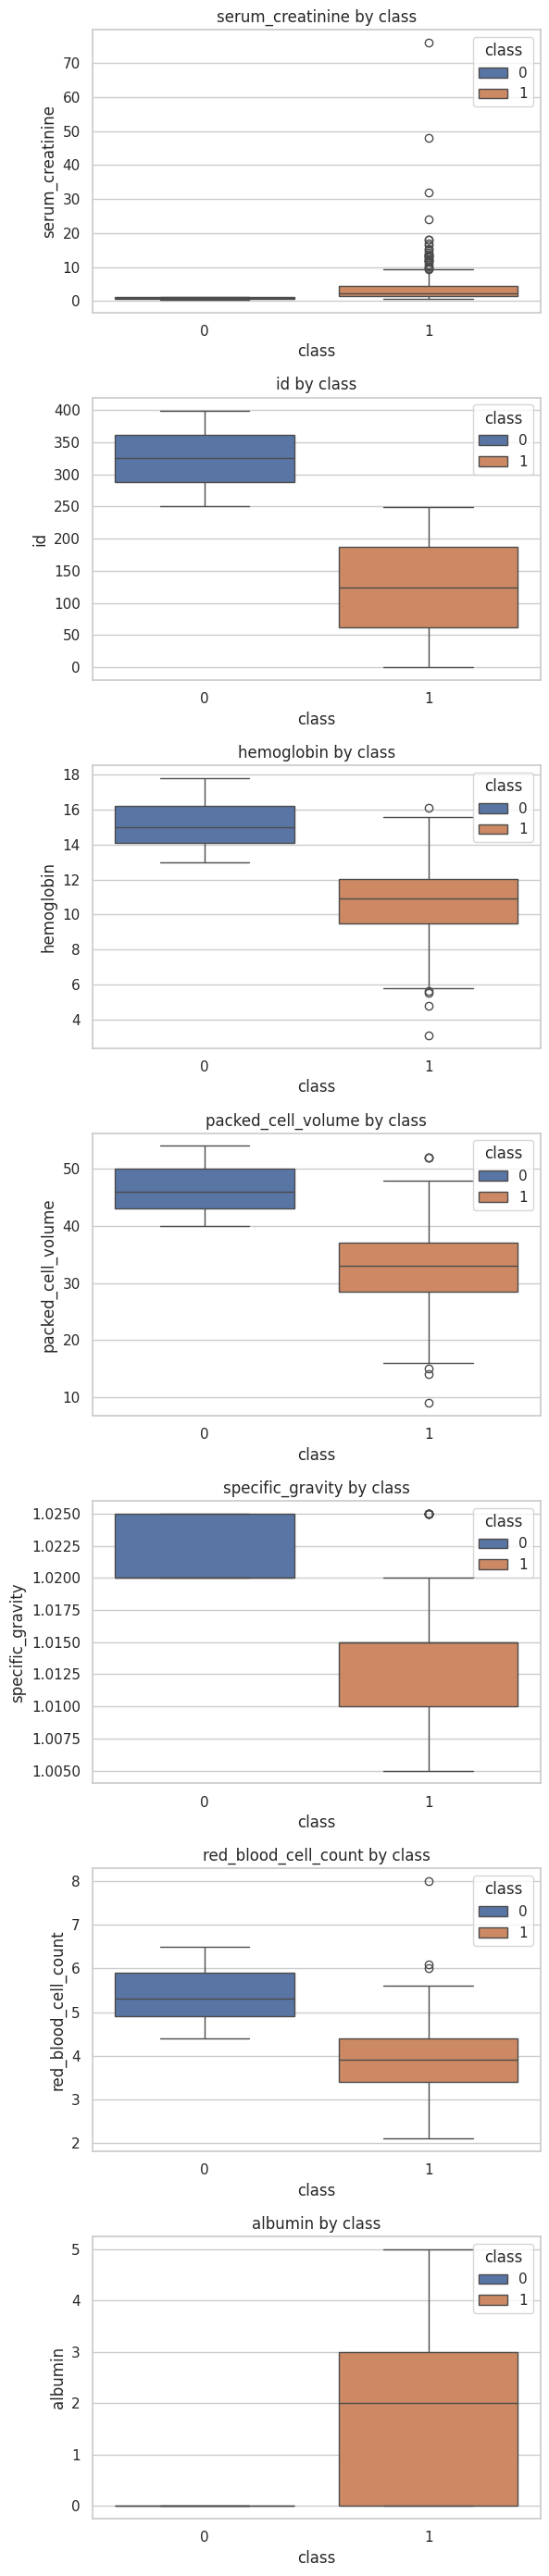

EDA Summary:
- Noted overall missingness per column (see bar chart).
- Examined class balance (bar chart).
- Reviewed numeric distributions (describe).
- Explored correlations to target and visualized top features via boxplots.


In [ ]:
# Missing values bar plot
na_counts = df.isna().sum().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
na_counts[na_counts>0].plot(kind='bar')
plt.title('Missing Values per Column')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Class balance
plt.figure(figsize=(5,4))
df[TARGET_COL].value_counts().plot(kind='bar')
plt.title('Target Class Distribution')
plt.xlabel('Class (0=not-CKD, 1=CKD)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Basic descriptive stats for numeric columns
num_cols = df.select_dtypes(include=[np.number]).columns.drop(TARGET_COL, errors='ignore')
desc = df[num_cols].describe().T
display(desc)

# Correlation heatmap (numeric only)
plt.figure(figsize=(11, 9))
corr = df[num_cols.tolist() + [TARGET_COL]].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt='.1f')
plt.title('Correlation Heatmap (numeric features)')
plt.tight_layout()
plt.show()

# Boxplots for a few top-correlated features vs target (if any)
corr_to_y = corr[TARGET_COL].drop(TARGET_COL).abs().sort_values(ascending=False)
# Ensure 'serum_creatinine' is included in the top features to plot
top_feats_base = corr_to_y.head(min(6, len(corr_to_y))).index.tolist()
if 'serum_creatinine' not in top_feats_base:
    top_feats = ['serum_creatinine'] + top_feats_base
else:
    top_feats = top_feats_base


if top_feats:
    n = len(top_feats)
    fig, axes = plt.subplots(n, 1, figsize=(6D, 4*n))
    if n == 1:
        axes = [axes]
    for ax, col in zip(axes, top_feats):
        sns.boxplot(x=TARGET_COL, y=col, data=df, ax=ax, hue=TARGET_COL) # Added hue=TARGET_COL
        ax.set_title(f"{col} by class")
    plt.tight_layout()
    plt.show()

# EDA conclusion (printed summary)
print("EDA Summary:\n"
      "- Noted overall missingness per column (see bar chart).\n"
      "- Examined class balance (bar chart).\n"
      "- Reviewed numeric distributions (describe).\n"
      "- Explored correlations to target and visualized top features via boxplots.")

## 6. Preprocessing
- Split train/test with stratification
- Impute: median for numeric, most_frequent for categorical
- Encode: One-hot for multi-category object columns not mapped above
- Scale: Standardize numeric features

We build a `ColumnTransformer` + `Pipeline` to keep preprocessing consistent across models.

In [ ]:
from sklearn.impute import SimpleImputer

# Identify columns again after cleaning/mapping
num_cols = df.select_dtypes(include=[np.number]).columns.drop(TARGET_COL, errors='ignore').tolist()
cat_cols = [c for c in df.columns if c not in num_cols + [TARGET_COL]]

X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ]
)

print(f"Numeric cols: {len(num_cols)} | Categorical cols: {len(cat_cols)}")

Numeric cols: 23 | Categorical cols: 2


In [ ]:
from sklearn import set_config
set_config(display='diagram')
preprocess

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['id', 'age', 'blood_pressure',
                                  'specific_gravity', 'albumin', 'sugar',
                                  'red_blood_cells', 'pus_cell',
                                  'blood_glucose_random', 'blood_urea',
                                  'serum_creatinine', 'sodium', 'potassium',
                                  'hemoglobin', 'packed_cell_volume',
                                  'white_blood_cell_count',
                                  'red_blood_cell_count', 'hypertension',
                                  'diabetes_mellitus',
                                  'coronary_artery_disease', 'appetite',
                                  'pedal_edema', 'anemia']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['pus_cell_clumps', 'bacteria'])])

## 7. Train Models (Classical ML)

In [ ]:
models = {
    'LogisticRegression': LogisticRegression(max_iter=2000, class_weight='balanced'),
    'DecisionTree': DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    'SVM-RBF': SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=7),
    'XGBoost': XGBClassifier(n_estimators=400, max_depth=4, learning_rate=0.05, subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0, random_state=42, n_jobs=-1, eval_metric='logloss')
}

trained = {}
for name, clf in models.items():
    pipe = Pipeline(steps=[('preprocess', preprocess),
                          ('clf', clf)])
    pipe.fit(X_train, y_train)
    trained[name] = pipe

print(f"Trained {len(trained)} models: {list(trained.keys())}")

Trained 5 models: ['LogisticRegression', 'DecisionTree', 'SVM-RBF', 'KNN', 'XGBoost']


## 8. Evaluation & Comparison Table

In [ ]:
def evaluate_model(pipe, X_test, y_test):
    y_pred = pipe.predict(X_test)
    # Handle predict_proba availability
    if hasattr(pipe.named_steps['clf'], 'predict_proba'):
        y_prob = pipe.predict_proba(X_test)[:,1]
    else:
        # Fallback using decision_function if available
        if hasattr(pipe.named_steps['clf'], 'decision_function'):
            # scale to 0-1 via min-max for AUC; not perfect but workable
            dec = pipe.decision_function(X_test)
            m, M = dec.min(), dec.max()
            y_prob = (dec - m) / (M - m + 1e-9)
        else:
            # Last resort: use predictions as probabilities (bad for AUC)
            y_prob = y_pred.astype(float)
    return {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred, zero_division=0),
        'F1': f1_score(y_test, y_pred, zero_division=0),
        'ROC_AUC': roc_auc_score(y_test, y_prob)
    }

rows = []
for name, pipe in trained.items():
    met = evaluate_model(pipe, X_test, y_test)
    row = {'Model': name}
    row.update(met)
    rows.append(row)

perf = pd.DataFrame(rows).sort_values(by=['F1','ROC_AUC','Accuracy'], ascending=False).reset_index(drop=True)
perf.style.format({'Accuracy': '{:.3f}', 'Precision':'{:.3f}', 'Recall':'{:.3f}', 'F1':'{:.3f}', 'ROC_AUC':'{:.3f}'})

,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,DecisionTree,1.000,1.000,1.000,1.000,1.000
1,XGBoost,1.000,1.000,1.000,1.000,1.000
2,LogisticRegression,0.992,1.000,0.987,0.993,1.000
3,SVM-RBF,0.992,1.000,0.987,0.993,1.000
4,KNN,0.983,1.000,0.973,0.986,1.000


### Confusion Matrices for Top 3 Models

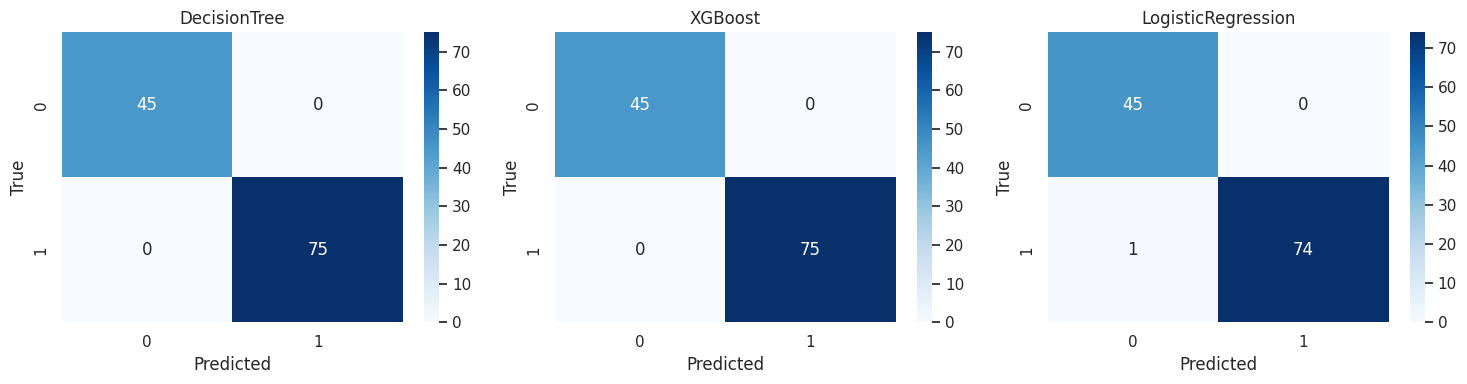

In [ ]:
top3 = perf.head(3)['Model'].tolist()
fig, axes = plt.subplots(1, len(top3), figsize=(5*len(top3), 4))
if len(top3) == 1:
    axes = [axes]

for ax, name in zip(axes, top3):
    pipe = trained[name]
    cm = confusion_matrix(y_test, pipe.predict(X_test))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(name)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

plt.tight_layout()
plt.show()

### ROC Curves for Top 3 Models

<Figure size 700x500 with 0 Axes>

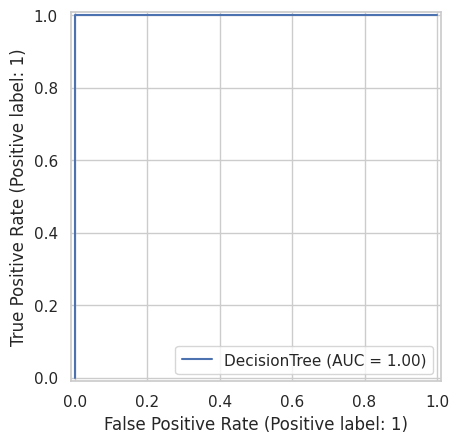

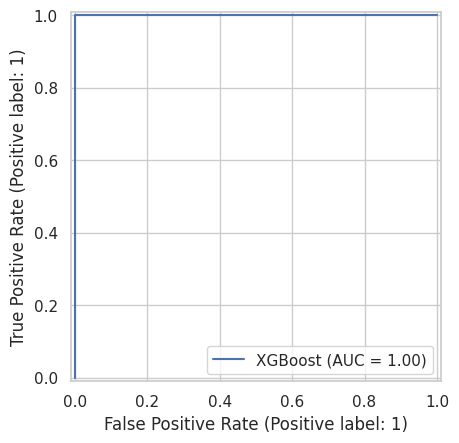

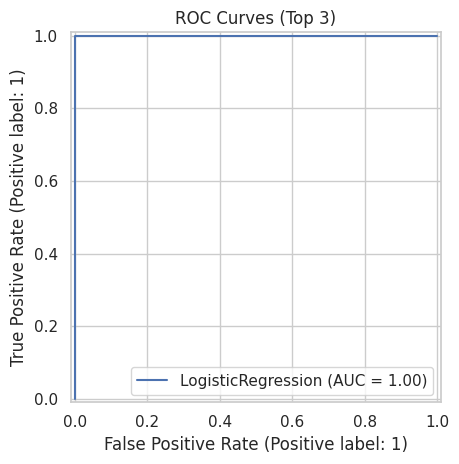

In [ ]:
plt.figure(figsize=(7,5))
for name in top3:
    pipe = trained[name]
    if hasattr(pipe.named_steps['clf'], 'predict_proba') or hasattr(pipe.named_steps['clf'], 'decision_function'):
        RocCurveDisplay.from_estimator(pipe, X_test, y_test, name=name)
plt.title('ROC Curves (Top 3)')
plt.tight_layout()
plt.show()

## 9. Conclusion
All models are evaluated using Accuracy, Precision, Recall, F1, and ROC_AUC. Review the comparison table to choose a tradeoff that fits your needs. Given typical CKD datasets, tree ensembles (RandomForest/GradientBoosting/XGBoost) and well-regularized linear or MLP models often perform strongly. For production, consider cross-validation, hyperparameter tuning, and calibration.


## 10. Save Model

Choose a model which perform good and have a acceptable best accuracy. Don't choose the model which has 1.00 (100%) accuracy because it may a chance of over fitten model.


In [ ]:
import pickle
import os

model_name = 'LogisticRegression'
model_to_save = trained[model_name]

SAVE_PATH = '/content/drive/MyDrive/Models/trained_ckd_model.pkl'

os.makedirs(os.path.dirname(SAVE_PATH), exist_ok=True)

with open(SAVE_PATH, 'wb') as f:
    pickle.dump(model_to_save, f)

print(f"Model '{model_name}' saved successfully to {SAVE_PATH}")

Model 'LogisticRegression' saved successfully to /content/drive/MyDrive/Models/trained_ckd_model.pkl
